# Seleção de Features
# 
Using the Titanic dataset from [this](https://www.kaggle.com/c/titanic/overview) Kaggle competition.

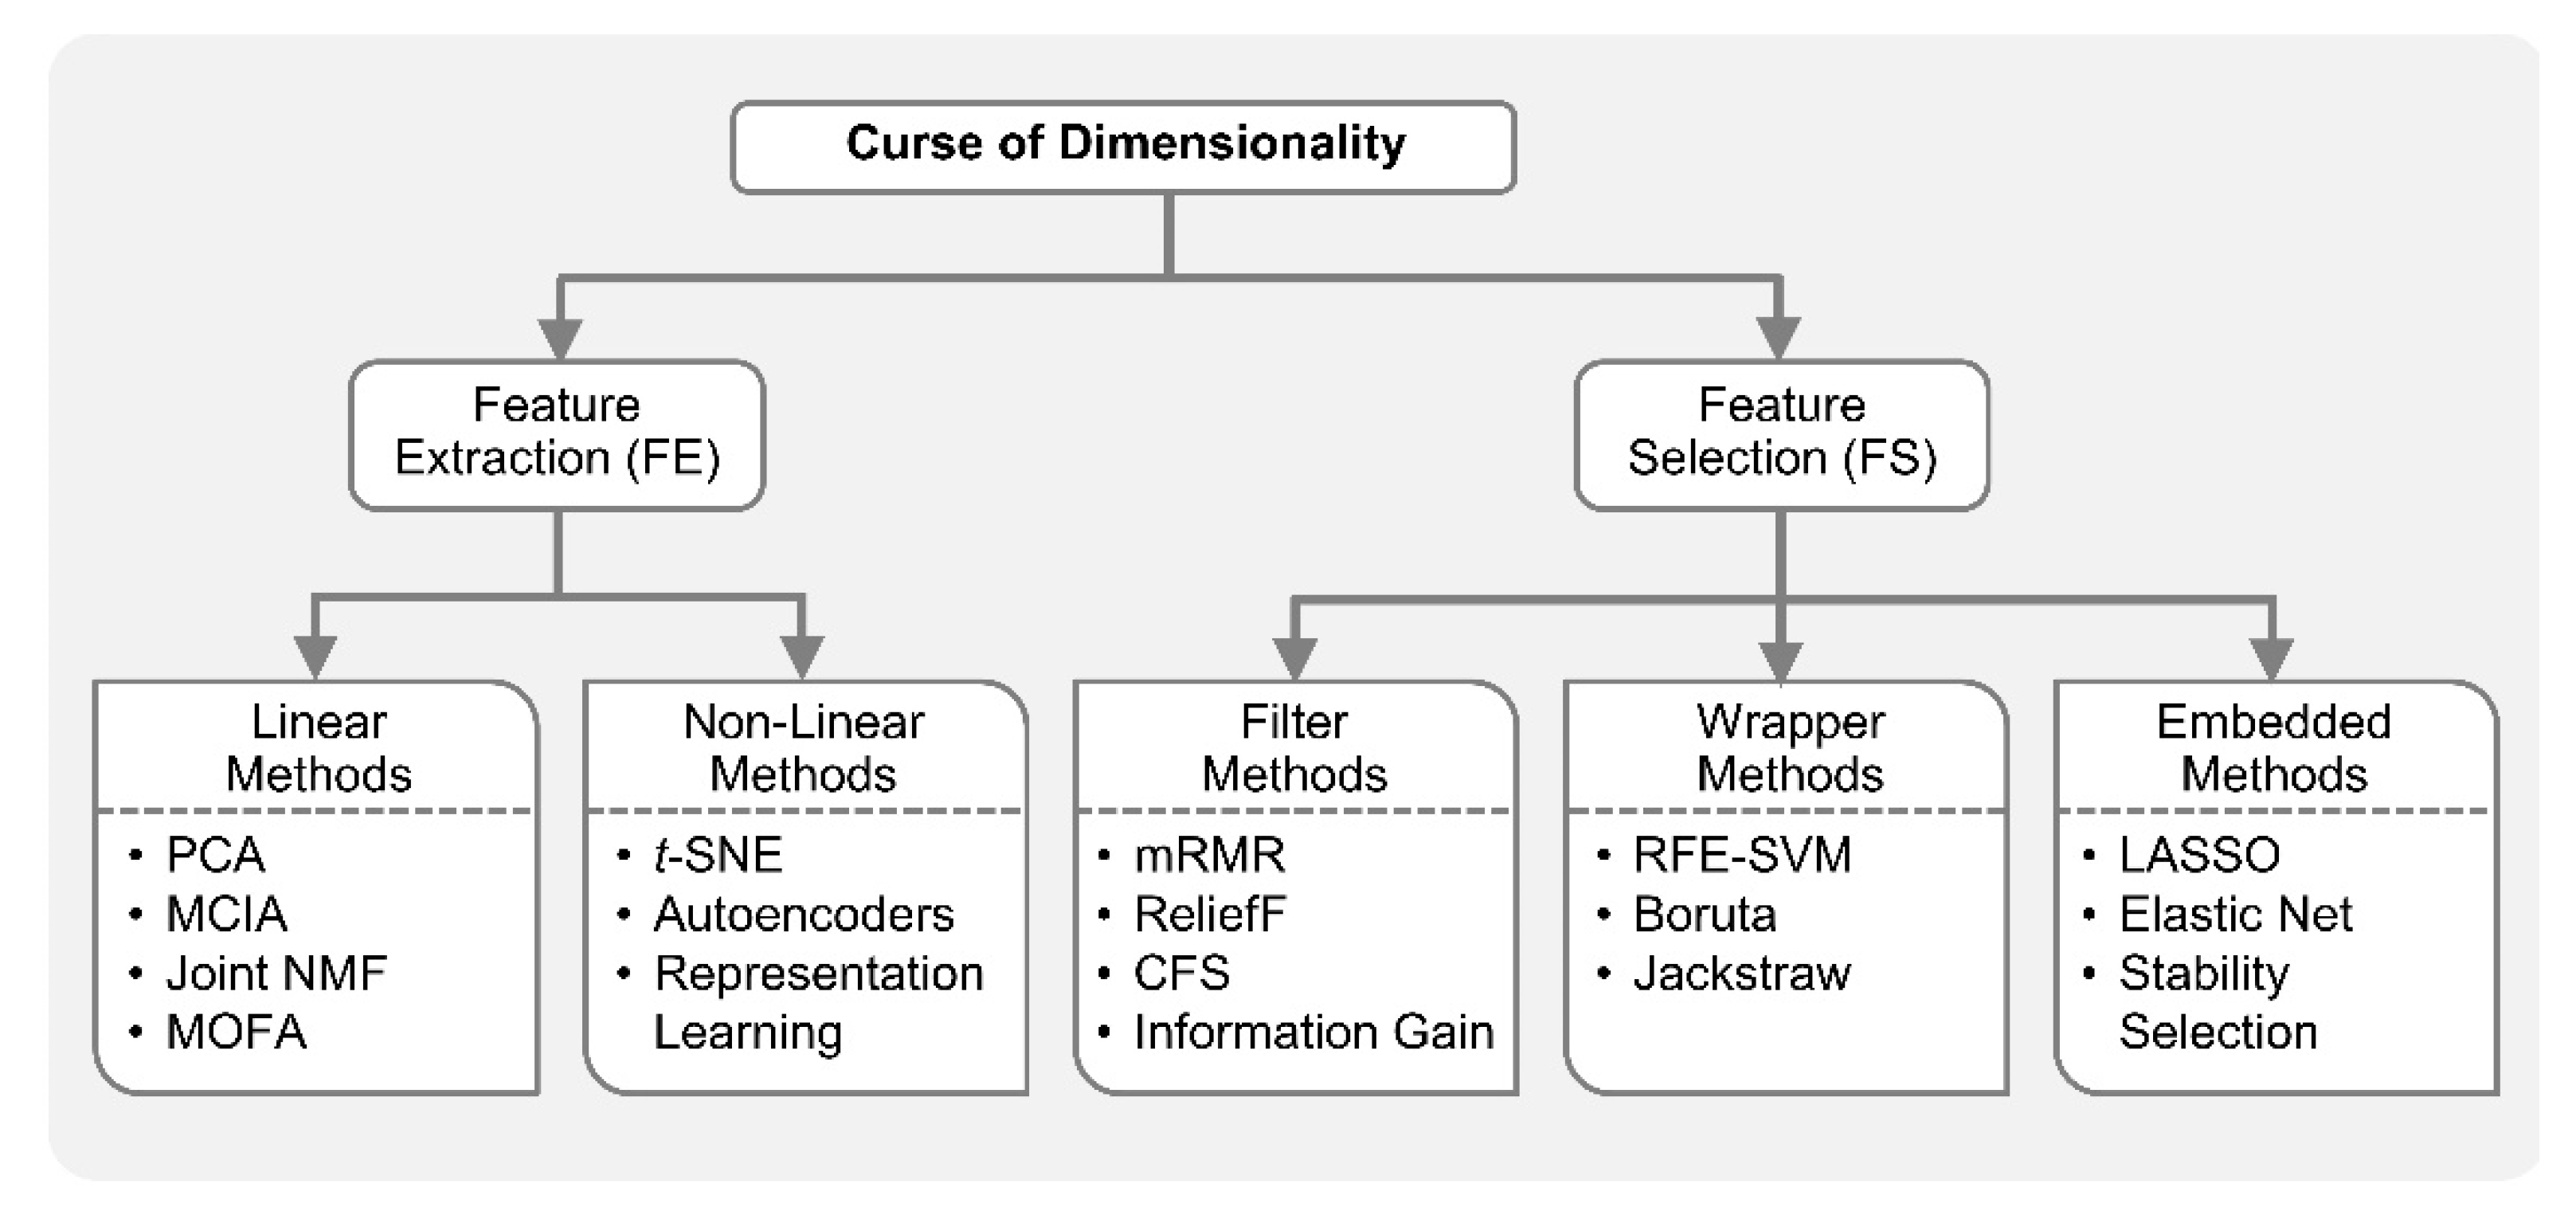

# Ler Dados
Separar Dados em Treinamento e Teste 70/30

In [ ]:
import joblib
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
import pandas as pd
from sklearn.model_selection import train_test_split
titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
titanic.head()
features = titanic.drop('Survived', axis=1)
labels = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, random_state=42)
for dataset in [y_train, y_test]:
    print(round(len(dataset) / len(labels), 2), len(dataset))

print("Train:",(y_train.values.tolist()).count(0),"(non-survive)",(y_train.values.tolist()).count(1),"(survive)")
print("Test :",(y_test.values.tolist()).count(0),"(non-survive)",(y_test.values.tolist()).count(1),"(survive)")


# Plotar Matriz de Confusão

In [ ]:
def cm(tn,fp,fn,tp):   
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sn
    import pandas as pd
    import seaborn as sns
    import math
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl
    mpl.style.use('seaborn')
    conf_arr = np.array([[tn,fp],[fn,tp]])
    sum = conf_arr.sum()
    df_cm = pd.DataFrame(conf_arr,
      index = ['Non-Survive', 'Survive'],
      columns = ['Non-Survive', 'Survive'])
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    cmap=sns.color_palette("flare", as_cmap=True)
    res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.0f', 
                     cmap=cmap, annot_kws={"size": 30})
    plt.yticks([0.5,1.5], [ 'Non-Survive', 'Survive'],va='center',fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel('Predicted',fontsize=20)
    plt.ylabel('True',fontsize=20)

# Shannon entropy para medir o desbalanceamento

On a data set of n instances, if you have k classes of size ci you can compute entropy as follows:
$H = -\sum_{ i = 1}^k \frac{c_i}{n} \log{ \frac{c_i}{n}}$.
This is equal to:

0 when there is one single class. In other words, it tends to 0 when your data set is very unbalanced
logk when all your classes are balanced of the same size $\frac{n}{k}$
Therefore, you could use the following measure of Balance for a data set:
$\mbox{Balance} = \frac{H}{\log{k}} = \frac{-\sum_{ i = 1}^k \frac{c_i}{n} \log{ \frac{c_i}{n}}.  } {\log{k}}$
which is equal to:

0 for a unbalanced data set

1 for a balanced data set



In [ ]:
import pandas as pd
import scipy.stats
def balance(seq):
    from collections import Counter
    from numpy import log
    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)
    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) #shannon entropy
    return H/log(k)

In [ ]:
print("Train:",(y_train.values.tolist()).count(0),"(non-survive)",(y_train.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_train))

# Classificador MLP + CV 30/70 sem realizar Balanceamento de Classe

In [ ]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix


import plotly.express as px
from sklearn.decomposition import PCA
X = X_train[["Pclass", "Sex", "Age", "Fare", "Family_cnt", "Cabin_ind"]]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = px.scatter(components, x=0, y=1, color=y_train)
fig.show()

print("Train:",(y_train.values.tolist()).count(0),"(non-survive)",(y_train.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_train))


param_grid = [{'activation': ['logistic', 'tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'learning_rate_init': [0.001, 0.01],
             'hidden_layer_sizes': [(10, 10, 2), (4, 4), (5, 10, 5)],
             'random_state': [1]}]
#model = MLPClassifier()
model = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=0)

pred=model.fit(X_train, y_train).predict(X_test)
tn,fp,fn,tp = (confusion_matrix(y_test,pred,labels=[0,1]).ravel())
print (tn,fp,fn,tp)

print("Especificidade:",round(tn/(tn+fp),3))
print("Sensibilidade/Recall:",round(tp/(tp+fn),3))
print("Precisão",round(tp/(tp+fp),3))
print("Acurácia:",round((tp+tn)/(tn+fp+fn+tp),3))
print("F1-score:",round(2*((tp/(tp+fn)) * (tp/(tp+fp))) / ((tp/(tp+fn)) + (tp/(tp+fp))),3))
cm(tn,fp,fn,tp)

model.best_estimator_

#             Balanceamento de Classe usando SMOTE + Classificador MLP + CV 30/70

In [ ]:
import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

sm = SMOTE(random_state=0)
X_trainB,  y_trainB = sm.fit_resample(X_train,y_train)

import plotly.express as px
from sklearn.decomposition import PCA
X = X_trainB[["Pclass", "Sex", "Age", "Fare", "Family_cnt", "Cabin_ind"]]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = px.scatter(components, x=0, y=1, color=y_trainB)
fig.show()

print("Train:",(y_trainB.values.tolist()).count(0),"(non-survive)",(y_trainB.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_trainB))

param_grid = [{'activation': ['logistic', 'tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'learning_rate_init': [0.001, 0.01],
             'hidden_layer_sizes': [(10, 10, 2), (4, 4), (5, 10, 5)],
             'random_state': [1]}]
#model = MLPClassifier()
model = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=0)

pred=model.fit(X_trainB, y_trainB).predict(X_test)
tn,fp,fn,tp = (confusion_matrix(y_test,pred,labels=[0,1]).ravel())
print (tn,fp,fn,tp)

print("Especificidade:",round(tn/(tn+fp),3))
print("Sensibilidade/Recall:",round(tp/(tp+fn),3))
print("Precisão",round(tp/(tp+fp),3))
print("Acurácia:",round((tp+tn)/(tn+fp+fn+tp),3))
print("F1-score:",round(2*((tp/(tp+fn)) * (tp/(tp+fp))) / ((tp/(tp+fn)) + (tp/(tp+fp))),3))
cm(tn,fp,fn,tp)

model.best_estimator_

# Univariate feature selection

A seleção de características univariadas funciona através da seleção das melhores características com base em testes estatísticos univariados. Pode ser visto como uma etapa de pré-processamento para um estimador.

SelectKBest removes all but the  highest scoring features

SelectPercentile removes all but a user-specified highest scoring percentage of features using common univariate statistical tests for each feature: false positive rate SelectFpr, false discovery rate SelectFdr, or family wise error SelectFwe.



# Ranking de importancia de features

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#select = SelectKBest(score_func=chi2, k=3)
#z = select.fit_transform(X_train,y_train)

titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
print(titanic.head())
features = titanic.drop('Survived', axis=1)
labels = titanic['Survived']

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(features,labels)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print 



# Induzindo Modelo usando as 4 top features

In [ ]:
import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Survived', 'Age','Family_cnt'], axis=1)
print (features.head())
labels = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, random_state=42)


sm = SMOTE(random_state=0)
X_trainB,  y_trainB = sm.fit_resample(X_train,y_train)

import plotly.express as px
from sklearn.decomposition import PCA
X = X_trainB[["Pclass", "Sex", "Fare","Cabin_ind"]]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = px.scatter(components, x=0, y=1, color=y_trainB)
fig.show()

print("Train:",(y_trainB.values.tolist()).count(0),"(non-survive)",(y_trainB.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_trainB))

param_grid = [{'activation': ['logistic', 'tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'learning_rate_init': [0.001, 0.01],
             'hidden_layer_sizes': [(10, 10, 2), (4, 4), (5, 10, 5)],
             'random_state': [1]}]
#model = MLPClassifier()
model = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=0)

pred=model.fit(X_trainB, y_trainB).predict(X_test)
tn,fp,fn,tp = (confusion_matrix(y_test,pred,labels=[0,1]).ravel())
print (tn,fp,fn,tp)

print("Especificidade:",round(tn/(tn+fp),3))
print("Sensibilidade/Recall:",round(tp/(tp+fn),3))
print("Precisão",round(tp/(tp+fp),3))
print("Acurácia:",round((tp+tn)/(tn+fp+fn+tp),3))
print("F1-score:",round(2*((tp/(tp+fn)) * (tp/(tp+fp))) / ((tp/(tp+fn)) + (tp/(tp+fp))),3))
cm(tn,fp,fn,tp)

model.best_estimator_

In [ ]:
import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Survived', 'Age','Family_cnt'], axis=1)
print (features.head())
labels = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, random_state=42)


sm = SMOTE(random_state=0)
X_trainB,  y_trainB = sm.fit_resample(X_train,y_train)

import plotly.express as px
from sklearn.decomposition import PCA
X = X_trainB[["Pclass", "Sex", "Fare","Cabin_ind"]]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = px.scatter(components, x=0, y=1, color=y_trainB)
fig.show()

print("Train:",(y_trainB.values.tolist()).count(0),"(non-survive)",(y_trainB.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_trainB))

param_grid = [{'activation': ['logistic', 'tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'learning_rate_init': [0.001, 0.01],
             'hidden_layer_sizes': [(10, 10, 2), (4, 4), (5, 10, 5)],
             'random_state': [1]}]
#model = MLPClassifier()
model = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=0)

pred=model.fit(X_trainB, y_trainB).predict(X_test)
tn,fp,fn,tp = (confusion_matrix(y_test,pred,labels=[0,1]).ravel())
print (tn,fp,fn,tp)

print("Especificidade:",round(tn/(tn+fp),3))
print("Sensibilidade/Recall:",round(tp/(tp+fn),3))
print("Precisão",round(tp/(tp+fp),3))
print("Acurácia:",round((tp+tn)/(tn+fp+fn+tp),3))
print("F1-score:",round(2*((tp/(tp+fn)) * (tp/(tp+fp))) / ((tp/(tp+fn)) + (tp/(tp+fp))),3))
cm(tn,fp,fn,tp)

model.best_estimator_

# Induzindo Modelo usando as 2 top features

In [ ]:
import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Pclass','Survived', 'Age','Family_cnt','Cabin_ind'], axis=1)
print (features.head())
labels = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, random_state=42)


sm = SMOTE(random_state=0)
X_trainB,  y_trainB = sm.fit_resample(X_train,y_train)

import plotly.express as px
from sklearn.decomposition import PCA
X = X_trainB[["Sex", "Fare"]]
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = px.scatter(components, x=0, y=1, color=y_trainB)
fig.show()

print("Train:",(y_trainB.values.tolist()).count(0),"(non-survive)",(y_trainB.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_trainB))

param_grid = [{'activation': ['logistic', 'tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'learning_rate_init': [0.001, 0.01],
             'hidden_layer_sizes': [(10, 10, 2), (4, 4), (5, 10, 5)],
             'random_state': [1]}]
#model = MLPClassifier()
model = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=0)

pred=model.fit(X_trainB, y_trainB).predict(X_test)
tn,fp,fn,tp = (confusion_matrix(y_test,pred,labels=[0,1]).ravel())
print (tn,fp,fn,tp)

print("Especificidade:",round(tn/(tn+fp),3))
print("Sensibilidade/Recall:",round(tp/(tp+fn),3))
print("Precisão",round(tp/(tp+fp),3))
print("Acurácia:",round((tp+tn)/(tn+fp+fn+tp),3))
print("F1-score:",round(2*((tp/(tp+fn)) * (tp/(tp+fp))) / ((tp/(tp+fn)) + (tp/(tp+fp))),3))
cm(tn,fp,fn,tp)

model.best_estimator_

# Correlation Matrix with Heatmap

Correlation states how the features are related to each other or the target variable.
Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)
Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

In [ ]:
titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Survived'], axis=1)
print (features.head())
labels = titanic['Survived']


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
X = features  #independent columns
y =labels   #target column i.e price range
#get correlations of each features in dataset
corrmat = titanic.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(titanic[top_corr_features].corr(),annot=True,cmap="RdYlGn")



# Matriz de Correlação apenas das top 4 features

In [ ]:
titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Age','Family_cnt'], axis=1)

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

#get correlations of each features in dataset
corrmat = features.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(titanic[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_) or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Survived'], axis=1)
print (features.head())
labels = titanic['Survived']

# Create the RFE object and rank 
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=4, step=1)
rfe.fit(features, labels)

print(rfe.support_)
print(rfe.ranking_)

In [ ]:
import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

titanic = pd.read_csv('../input/titanic-cleaned/titanic_cleaned.csv')
features = titanic.drop(['Survived', 'Age','Fare'], axis=1)
print (features.head())
labels = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.3, random_state=42)


sm = SMOTE(random_state=0)
X_trainB,  y_trainB = sm.fit_resample(X_train,y_train)


print("Train:",(y_trainB.values.tolist()).count(0),"(non-survive)",(y_trainB.values.tolist()).count(1),"(survive)")
print ("Shannon Entropy:", balance(y_trainB))

param_grid = [{'activation': ['logistic', 'tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'learning_rate_init': [0.001, 0.01],
             'hidden_layer_sizes': [(10, 10, 2), (4, 4), (5, 10, 5)],
             'random_state': [1]}]
#model = MLPClassifier()
model = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=0)

pred=model.fit(X_trainB, y_trainB).predict(X_test)
tn,fp,fn,tp = (confusion_matrix(y_test,pred,labels=[0,1]).ravel())
print (tn,fp,fn,tp)

print("Especificidade:",round(tn/(tn+fp),3))
print("Sensibilidade/Recall:",round(tp/(tp+fn),3))
print("Precisão",round(tp/(tp+fp),3))
print("Acurácia:",round((tp+tn)/(tn+fp+fn+tp),3))
print("F1-score:",round(2*((tp/(tp+fn)) * (tp/(tp+fp))) / ((tp/(tp+fn)) + (tp/(tp+fp))),3))
cm(tn,fp,fn,tp)

model.best_estimator_